# Imports

In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
from IPython import embed
from skimage import color
from PIL import Image
from torch.utils.data import Dataset, IterableDataset
from torchsummary import summary
from tqdm.notebook import trange, tqdm
from torch.nn.utils.clip_grad import clip_grad_norm_
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import numpy as np
from skimage import color, io
import matplotlib.pyplot as plt
import torchvision.utils


In [17]:
# Hyper parameters and others
lr = 1e-3
epochs = 45
batch_size = 8
dp_save_path = "/content/dp.ckpt"
dp_save_path2 = "/content/dp2.ckpt"

# Data

In [3]:
# converts the PIL image to a pytorch tensor containing an LAB image
def import_image(img):
    return torch.FloatTensor(np.transpose(color.rgb2lab(np.array(img)), (2, 0, 1)))
    
img_transform = transforms.Compose([
    transforms.Lambda(import_image)
])
train_dataset = CIFAR10('./data/CIFAR10', train=True, transform=img_transform, target_transform=None, download=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CIFAR10('./data/CIFAR10', train=False, transform=img_transform, target_transform=None, download=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 170498071/170498071 [00:13<00:00, 12887466.15it/s]


Extracting ./data/CIFAR10/cifar-10-python.tar.gz to ./data/CIFAR10
Files already downloaded and verified


# Our Model

In [107]:
class ColorNet(nn.Module):
    def __init__(self, d=128):
        super(ColorNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1) 
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1) 
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1) 
        self.conv3_bn = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1) 
        self.conv4_bn = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1) 
        self.conv5_bn = nn.BatchNorm2d(256)
        # self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1) 
        # self.conv6_bn = nn.BatchNorm2d(256)
        # self.conv7 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1) 
        # self.conv7_bn = nn.BatchNorm2d(256)

        self.rconv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1) 
        self.rconv1_bn = nn.BatchNorm2d(128)
        self.rconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1) 
        self.rconv2_bn = nn.BatchNorm2d(64)
        self.rconv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1) 
        self.rconv3_bn = nn.BatchNorm2d(32)
        self.rconv4 = nn.ConvTranspose2d(32, 2, kernel_size=4, stride=2, padding=1) 

    def forward(self, input):
        x = F.relu(self.conv1_bn(self.conv1(input)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.relu(self.conv4_bn(self.conv4(x)))
        x = F.relu(self.conv5_bn(self.conv5(x)))
        # x = F.relu(self.conv6_bn(self.conv6(x)))
        # x = F.relu(self.conv7_bn(self.conv7(x)))

        x = F.relu(self.rconv1_bn(self.rconv1(x)))
        x = F.relu(self.rconv2_bn(self.rconv2(x)))
        x = F.relu(self.rconv3_bn(self.rconv3(x)))
        x = self.rconv4(x)

        return x

In [108]:
cmodel1 = ColorNet()
optimizer = torch.optim.Adam(params=cmodel1.parameters(), lr=lr)

In [109]:
def forward(x):
    res = cmodel1(x)
    return res 

def cal_loss(res, targets, pred_sizes, target_sizes):
    loss = F.mse_loss(res, targets)
    return loss

def train_batch(batch):
    batch = batch[0]
    inputs, targets = batch[:, 0:1, :, :], batch[:, 1:3, :, :]
    res = forward(inputs)

    loss = cal_loss(res, targets, 0, 0)
    return loss


def training_step(batch):
    loss = train_batch(batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return abs(loss.item())

if os.path.exists(dp_save_path):
  cmodel1.load_state_dict(torch.load(dp_save_path))

losses1 = []
# training loop
for epoch in range(0, epochs):
    pbar = None
    pbar = tqdm(train_dataloader, leave=True, total= len(train_dataloader))
    cmodel1.train()
    outputs = []

    for batch_nb, batch in enumerate(pbar):
        loss = training_step(batch)
        outputs.append(loss)
    

    train_result = np.mean(outputs)
    losses1.append(train_result)
    print('epoch = {}, train_loss = {}'.format(epoch, train_result)) 
    print("saving checkpoint")
    torch.save(cmodel1.state_dict(), dp_save_path)

  0%|          | 0/6250 [00:00<?, ?it/s]

epoch = 0, train_loss = 168.42449613220214
saving checkpoint


  0%|          | 0/6250 [00:00<?, ?it/s]

epoch = 1, train_loss = 162.09385216003417
saving checkpoint


  0%|          | 0/6250 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

#Rebalance loss

In [113]:
# def bmse_loss(inputs, targets, noise_sigma=8.):
#     return bmc_loss(inputs, targets, noise_sigma ** 2)

# def bmc_loss(pred, target, noise_var):
#     logits = - 0.5 * torch.pow(pred - target, 2) / noise_var
#     print(logits, torch.ones(logits.size()))
#     loss = F.cross_entropy(logits, torch.ones(logits.size())*torch.max(target))
#     print(loss)
#     loss = loss * (2 * noise_var)
#     return loss
def bmse_loss(inputs, targets):
    mse_loss = (inputs - targets) ** 2
    weights = torch.log(torch.abs(targets)+1)+1
    mse_loss = mse_loss*weights
    mse_loss = mse_loss.mean()
    return mse_loss

In [114]:
cmodel2 = ColorNet()
optimizer = torch.optim.Adam(params=cmodel2.parameters(), lr=lr)

In [115]:
def forward(x):
    res = cmodel2(x)
    return res 

def cal_loss(res, targets, pred_sizes, target_sizes):
    loss = bmse_loss(res, targets)
    return loss

def train_batch(batch):
    batch = batch[0]
    inputs, targets = batch[:, 0:1, :, :], batch[:, 1:3, :, :]
    res = forward(inputs)

    loss = cal_loss(res, targets, 0, 0)
    return loss


def training_step(batch):
    loss = train_batch(batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return abs(loss.item())

if os.path.exists(dp_save_path2):
  cmodel1.load_state_dict(torch.load(dp_save_path2))


  
losses2 = []
# training loop
for epoch in range(0, epochs):
    pbar = None
    pbar = tqdm(train_dataloader, leave=True, total= len(train_dataloader))
    cmodel2.train()
    outputs = []

    for batch_nb, batch in enumerate(pbar):
        loss = training_step(batch)
        outputs.append(loss)
    

    train_result = np.mean(outputs)
    losses2.append(train_result)

    print('epoch = {}, train_loss = {}'.format(epoch, train_result)) 
    print("saving checkpoint")
    torch.save(cmodel2.state_dict(), dp_save_path2)

  0%|          | 0/6250 [00:00<?, ?it/s]

epoch = 0, train_loss = 701.0726012670898
saving checkpoint


  0%|          | 0/6250 [00:00<?, ?it/s]

epoch = 1, train_loss = 671.0263915185546
saving checkpoint


  0%|          | 0/6250 [00:00<?, ?it/s]

epoch = 2, train_loss = 649.3853263769531
saving checkpoint


  0%|          | 0/6250 [00:00<?, ?it/s]

epoch = 3, train_loss = 627.9608735253906
saving checkpoint


  0%|          | 0/6250 [00:00<?, ?it/s]

epoch = 4, train_loss = 607.7431974230957
saving checkpoint


  0%|          | 0/6250 [00:00<?, ?it/s]

epoch = 5, train_loss = 589.5456471325683
saving checkpoint


  0%|          | 0/6250 [00:00<?, ?it/s]

epoch = 6, train_loss = 566.6761847998047
saving checkpoint


  0%|          | 0/6250 [00:00<?, ?it/s]

epoch = 7, train_loss = 544.4114011242676
saving checkpoint


  0%|          | 0/6250 [00:00<?, ?it/s]

epoch = 8, train_loss = 519.4394284057618
saving checkpoint


  0%|          | 0/6250 [00:00<?, ?it/s]

epoch = 9, train_loss = 494.43139420043946
saving checkpoint


  0%|          | 0/6250 [00:00<?, ?it/s]

epoch = 10, train_loss = 468.1487828955078
saving checkpoint


  0%|          | 0/6250 [00:00<?, ?it/s]

epoch = 11, train_loss = 443.50444315673826
saving checkpoint


  0%|          | 0/6250 [00:00<?, ?it/s]

epoch = 12, train_loss = 421.9844773657227
saving checkpoint


  0%|          | 0/6250 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

#Result

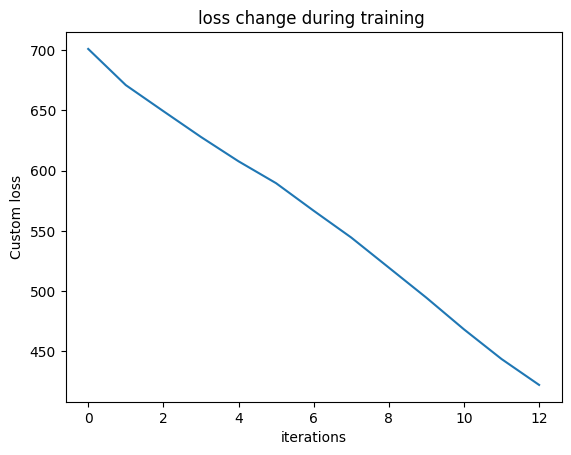

In [116]:
plt.plot(losses2)
plt.xlabel("iterations")
plt.ylabel("Custom loss")
plt.title("loss change during training ")
plt.show()

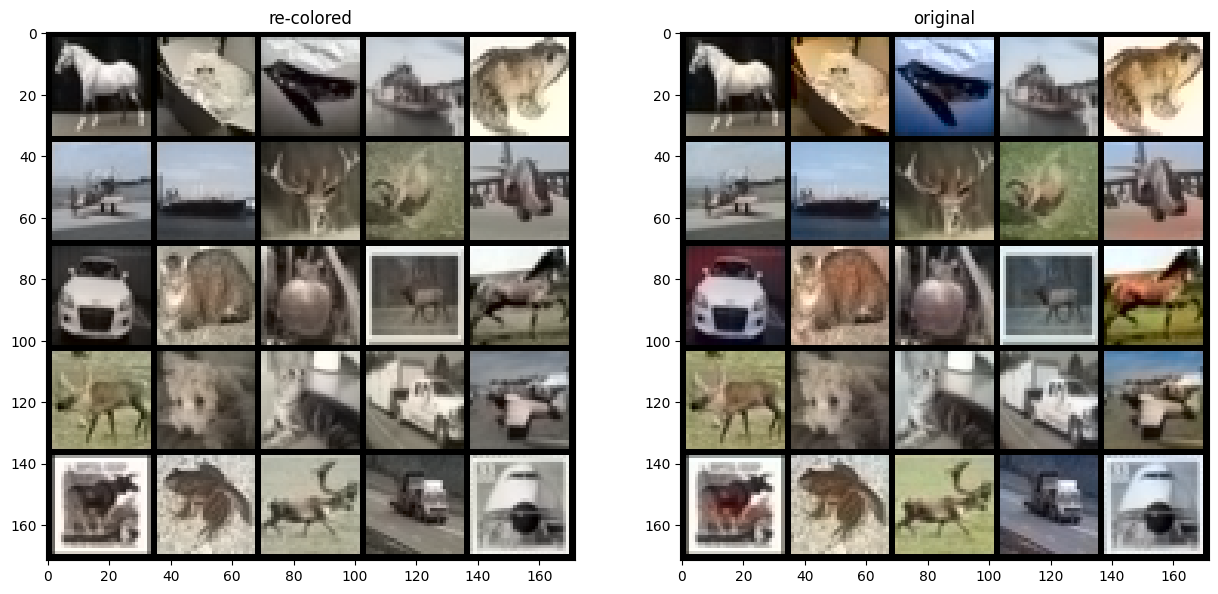

In [117]:
plt.ion()

with torch.no_grad():

    # pick a random subset of images from the test set
    image_inds = np.random.choice(len(train_dataset), 25, replace=False)
    lab_batch = torch.stack([train_dataset[i][0] for i in image_inds])
    # lab_batch = lab_batch.to(device)

    # predict colors (ab channels)
    predicted_ab_batch = cmodel1(lab_batch[:, 0:1, :, :])
    predicted_lab_batch = torch.cat([lab_batch[:, 0:1, :, :], predicted_ab_batch], dim=1)

    # predict colors (ab channels)
    predicted_ab_batch2 = cmodel2(lab_batch[:, 0:1, :, :])
    predicted_lab_batch2 = torch.cat([lab_batch[:, 0:1, :, :], predicted_ab_batch2], dim=1)

    lab_batch = lab_batch.cpu()
    predicted_lab_batch = predicted_lab_batch.cpu()
    predicted_lab_batch2 = predicted_lab_batch2.cpu()

    # convert to rgb
    rgb_batch = []
    predicted_rgb_batch = []
    for i in range(lab_batch.size(0)):
        # original
        # rgb_img = color.lab2rgb(np.transpose(lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
        # rgb_batch.append(torch.FloatTensor(np.transpose(rgb_img, (2, 0, 1))))

        # model 1
        rgb_img = color.lab2rgb(np.transpose(predicted_lab_batch2[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
        rgb_batch.append(torch.FloatTensor(np.transpose(rgb_img, (2, 0, 1))))

        #model 2
        predicted_rgb_img = color.lab2rgb(np.transpose(predicted_lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
        predicted_rgb_batch.append(torch.FloatTensor(np.transpose(predicted_rgb_img, (2, 0, 1))))

    # plot images
    fig, ax = plt.subplots(figsize=(15, 15), nrows=1, ncols=2)
    ax[0].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(predicted_rgb_batch), nrow=5).numpy(), (1, 2, 0)))
    ax[0].title.set_text('re-colored')
    ax[1].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(rgb_batch), nrow=5).numpy(), (1, 2, 0)))
    ax[1].title.set_text('original')
    plt.show()